# LoRA

- https://huggingface.co/docs/peft/main/en/task_guides/lora_based_methods
  - Image classification : low-rank decomposition methods에 집중하기 유리함

In [1]:
from datasets import load_dataset
from transformers import AutoImageProcessor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)
import torch

from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## * Dataset

In [2]:
# https://huggingface.co/datasets/ethz/food101
dataset = load_dataset("../data/huggingface/food101/")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [4]:
dataset["train"][0]

{'image': <PIL.Image.Image image mode=RGB size=384x512>, 'label': 6}

In [5]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [6]:
id2label[2]

'baklava'

## * Preprocessing

In [7]:
# Load an image processor to properly resize and normalize 
# the pixel values of the training and evaluation images:

# Vision Transformer : https://huggingface.co/google/vit-base-patch16-224-in21k
# Error in python3.7. Updated python3.10
model_name_or_path = "../model/huggingface/google/vit-base-patch16-224/"
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [8]:
normalize = Normalize(
    mean=image_processor.image_mean, 
    std=image_processor.image_std
)

train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize
    ]
)

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [9]:
train_dataset = dataset["train"]
val_dataset = dataset["validation"]

train_dataset.set_transform(preprocess_train)
val_dataset.set_transform(preprocess_val)

In [10]:
train_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=384x512>,
 'label': 6,
 'pixel_values': tensor([[[-0.7020, -0.7490, -0.7725,  ..., -0.9843, -0.9843, -0.9843],
          [-0.7961, -0.7569, -0.7647,  ..., -0.9922, -0.9843, -0.9843],
          [-0.7333, -0.7098, -0.7333,  ..., -0.9922, -0.9922, -0.9843],
          ...,
          [-0.1922, -0.2392, -0.2078,  ..., -0.1451, -0.1608, -0.1686],
          [-0.1529, -0.2000, -0.2000,  ..., -0.0824, -0.1137, -0.1451],
          [-0.2078, -0.2078, -0.1137,  ..., -0.2157, -0.1373, -0.0824]],
 
         [[-0.6627, -0.7176, -0.7412,  ..., -0.7647, -0.7804, -0.7804],
          [-0.7647, -0.7412, -0.7490,  ..., -0.7647, -0.7725, -0.7804],
          [-0.7098, -0.7020, -0.7255,  ..., -0.7569, -0.7647, -0.7725],
          ...,
          [-0.2392, -0.2784, -0.2471,  ..., -0.2627, -0.2784, -0.2863],
          [-0.2000, -0.2471, -0.2392,  ..., -0.2000, -0.2314, -0.2627],
          [-0.2549, -0.2471, -0.1529,  ..., -0.3333, -0.2549, -0.2000]],
 
         [[-0.

In [11]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## * Model

In [12]:
device="cuda:0"
print(model_name_or_path)

../model/huggingface/google/vit-base-patch16-224/


In [13]:
model = AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at ../model/huggingface/google/vit-base-patch16-224/ and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## * Lora

In [14]:
config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7713


In [15]:
model = model.to(device)

## * Before training

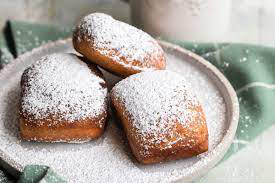

In [16]:
from PIL import Image

test_image = "../data/etc/beignets.jpeg"
image = Image.open(test_image)
image

In [17]:
test_encoding = image_processor(image.convert("RGB"), return_tensors="pt").to(device)

In [18]:
with torch.no_grad():
    outputs = model(**test_encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: gnocchi


## * Training

In [19]:
batch_size = 128
output_dir = "../model_output/google-vit-base-patch16-224/"

In [20]:
args = TrainingArguments(
    output_dir,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    label_names=["labels"]
)

/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    data_collator=collate_fn
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [22]:
trainer.train()

/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
0,1.957700,0.484346
2,0.655300,0.380919
4,0.578100,0.355284


/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home1/irteam/miniconda3/envs/jhyoon-py310/lib/python3.10/site-package

TrainOutput(global_step=90, training_loss=0.8248855166965061, metrics={'train_runtime': 2582.6751, 'train_samples_per_second': 146.65, 'train_steps_per_second': 0.035, 'total_flos': 2.88061030750363e+19, 'train_loss': 0.8248855166965061, 'epoch': 4.864864864864865})

In [23]:
with torch.no_grad():
    outputs = model(**test_encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: beignets
